## Bibliotecas

In [1]:
import datetime
import random
import pandas as pd
import numpy as np
import seaborn as sns
from pandas                        import Series
from tabulate                      import tabulate
from seaborn.matrix                import heatmap
from sklearn.linear_model          import LinearRegression
from sklearn.multioutput           import RegressorChain
from sklearn.multioutput           import MultiOutputRegressor
from xgboost                       import XGBRegressor
from sklearn.preprocessing         import MinMaxScaler, LabelEncoder,StandardScaler
from sklearn.metrics               import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics               import mean_squared_log_error as msle
from scipy                         import stats  as ss
from matplotlib                    import pyplot as plt
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import TimeSeriesSplit
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from joblib                        import Parallel, delayed
from tqdm.auto                     import tqdm
from sklearn.svm                   import SVR

## Funções gerais

In [2]:
# Funções: create_multistep_example, load_multistep_data, make_lags, make_multistep_target, plot_multistep
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

## Dados

In [36]:
train2 = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={'store_nbr':'category', 'family':'category', 'sales':'float32', 'onpromotion':'uint32'},
    parse_dates=['date'],
    infer_datetime_format=True,
)
#----------------------------------------------------------------------------------
train = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family','date', 'sales'],
    dtype = {'store_nbr':'category','family':'category'},
    parse_dates=['date'],
    infer_datetime_format=True,
)
test = pd.read_csv('test.csv', parse_dates = ['date'], infer_datetime_format = True)

In [37]:
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()


test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')

In [38]:
store_sales = train2.copy()

In [39]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [40]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
)

average_sales = store_sales.groupby('date').mean()['sales']

In [41]:
# Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(22, 10))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

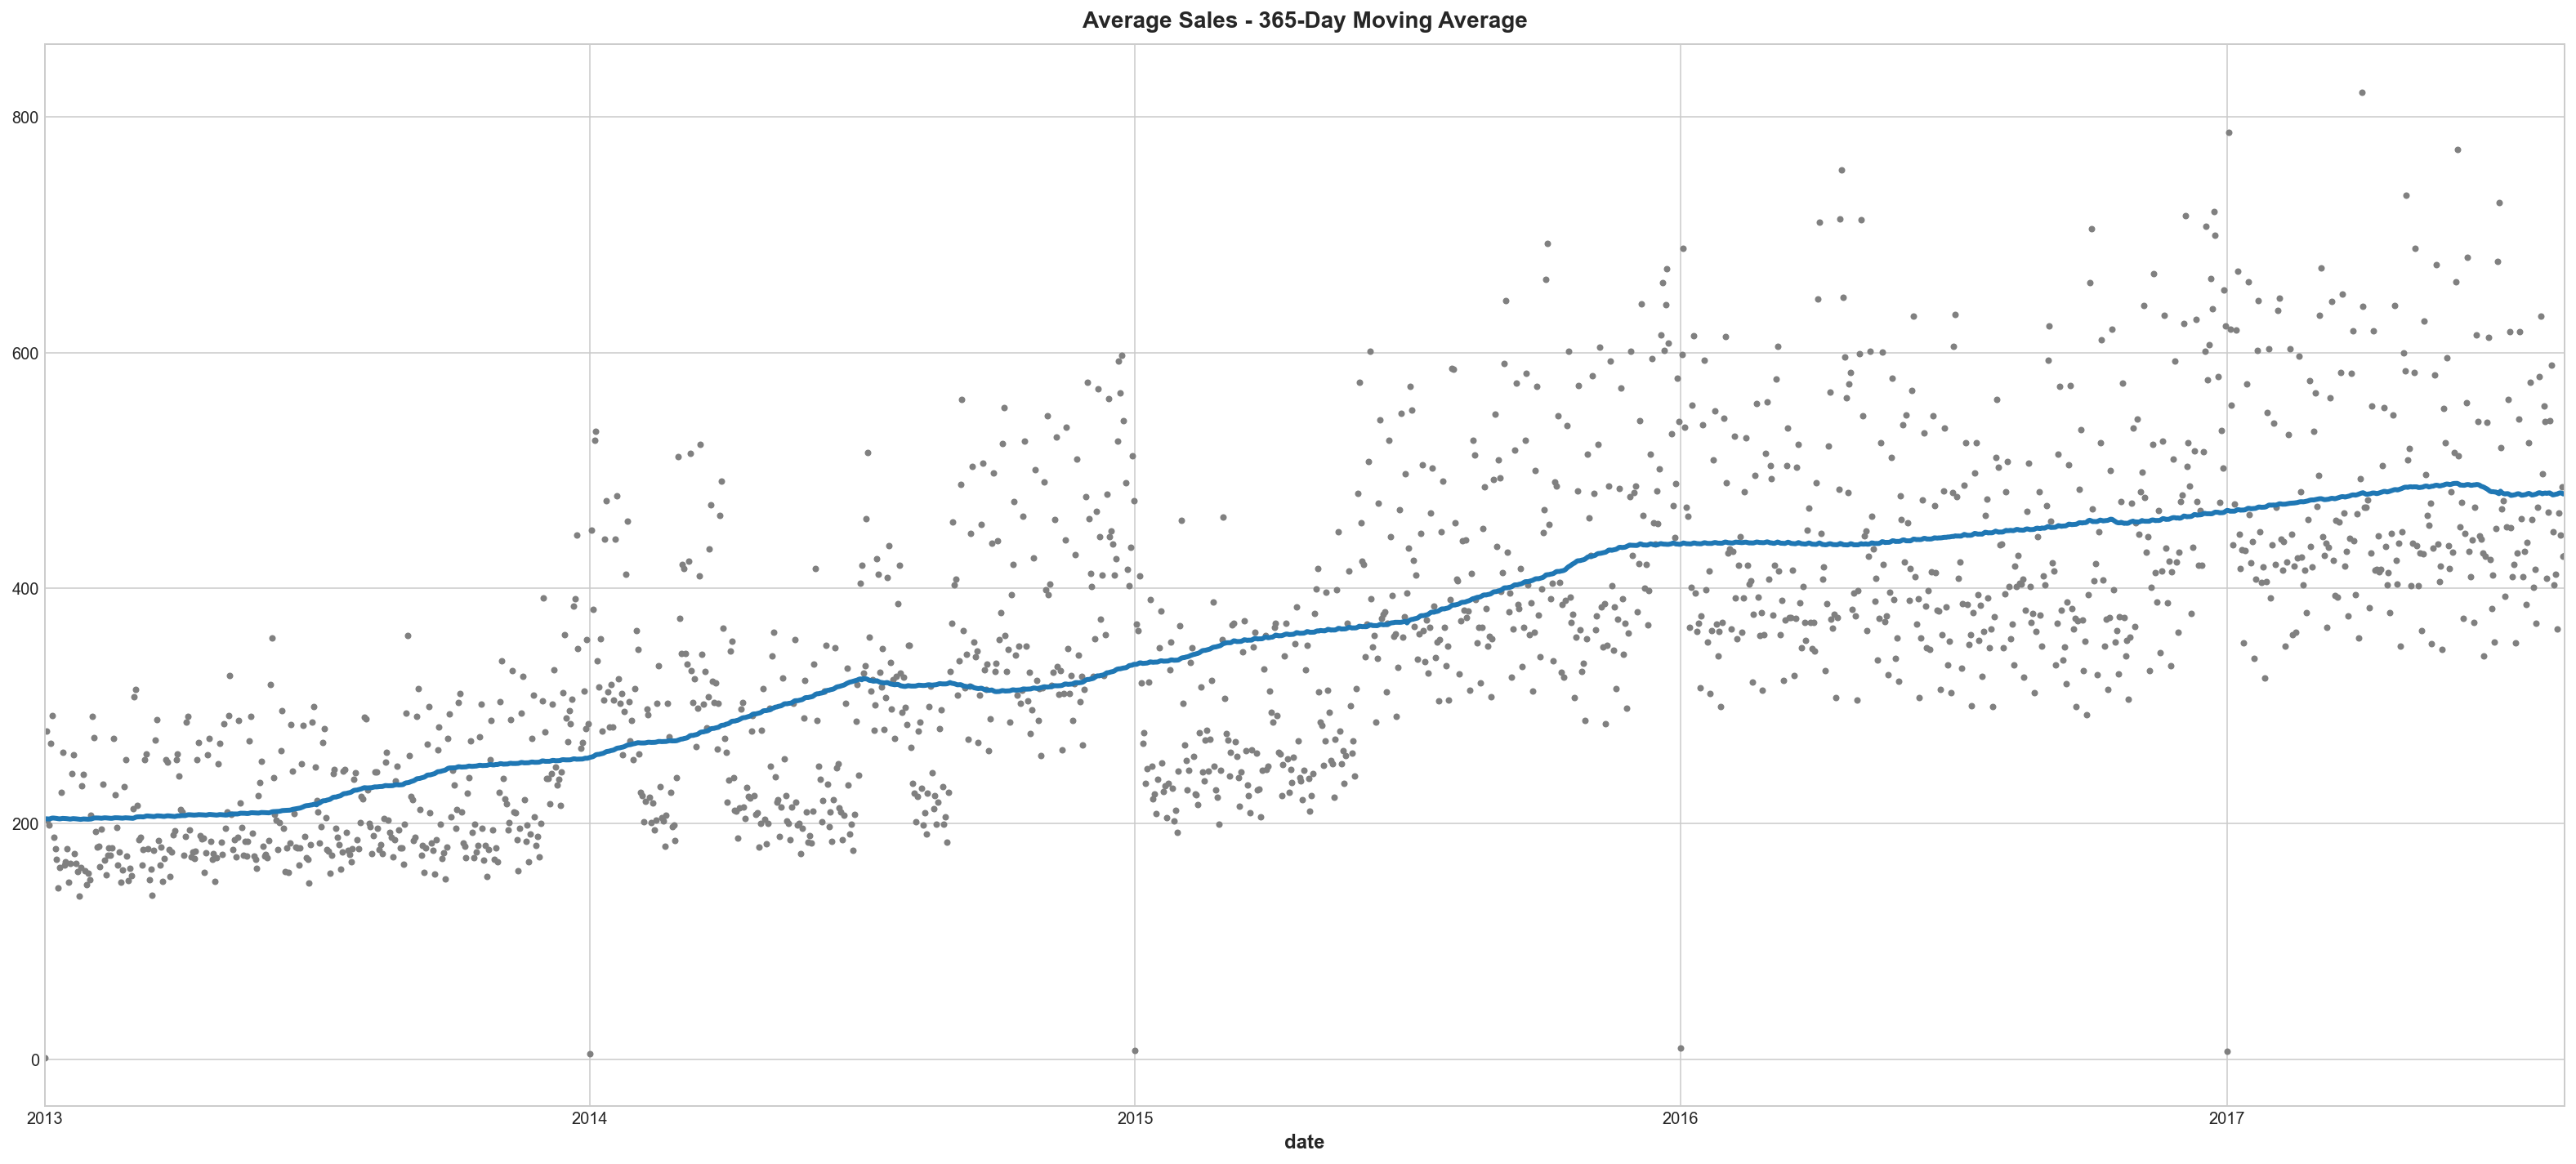

In [42]:
moving_average = average_sales.rolling(window=365, center=True, min_periods=183).mean()
ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Average Sales - 365-Day Moving Average", legend=False);

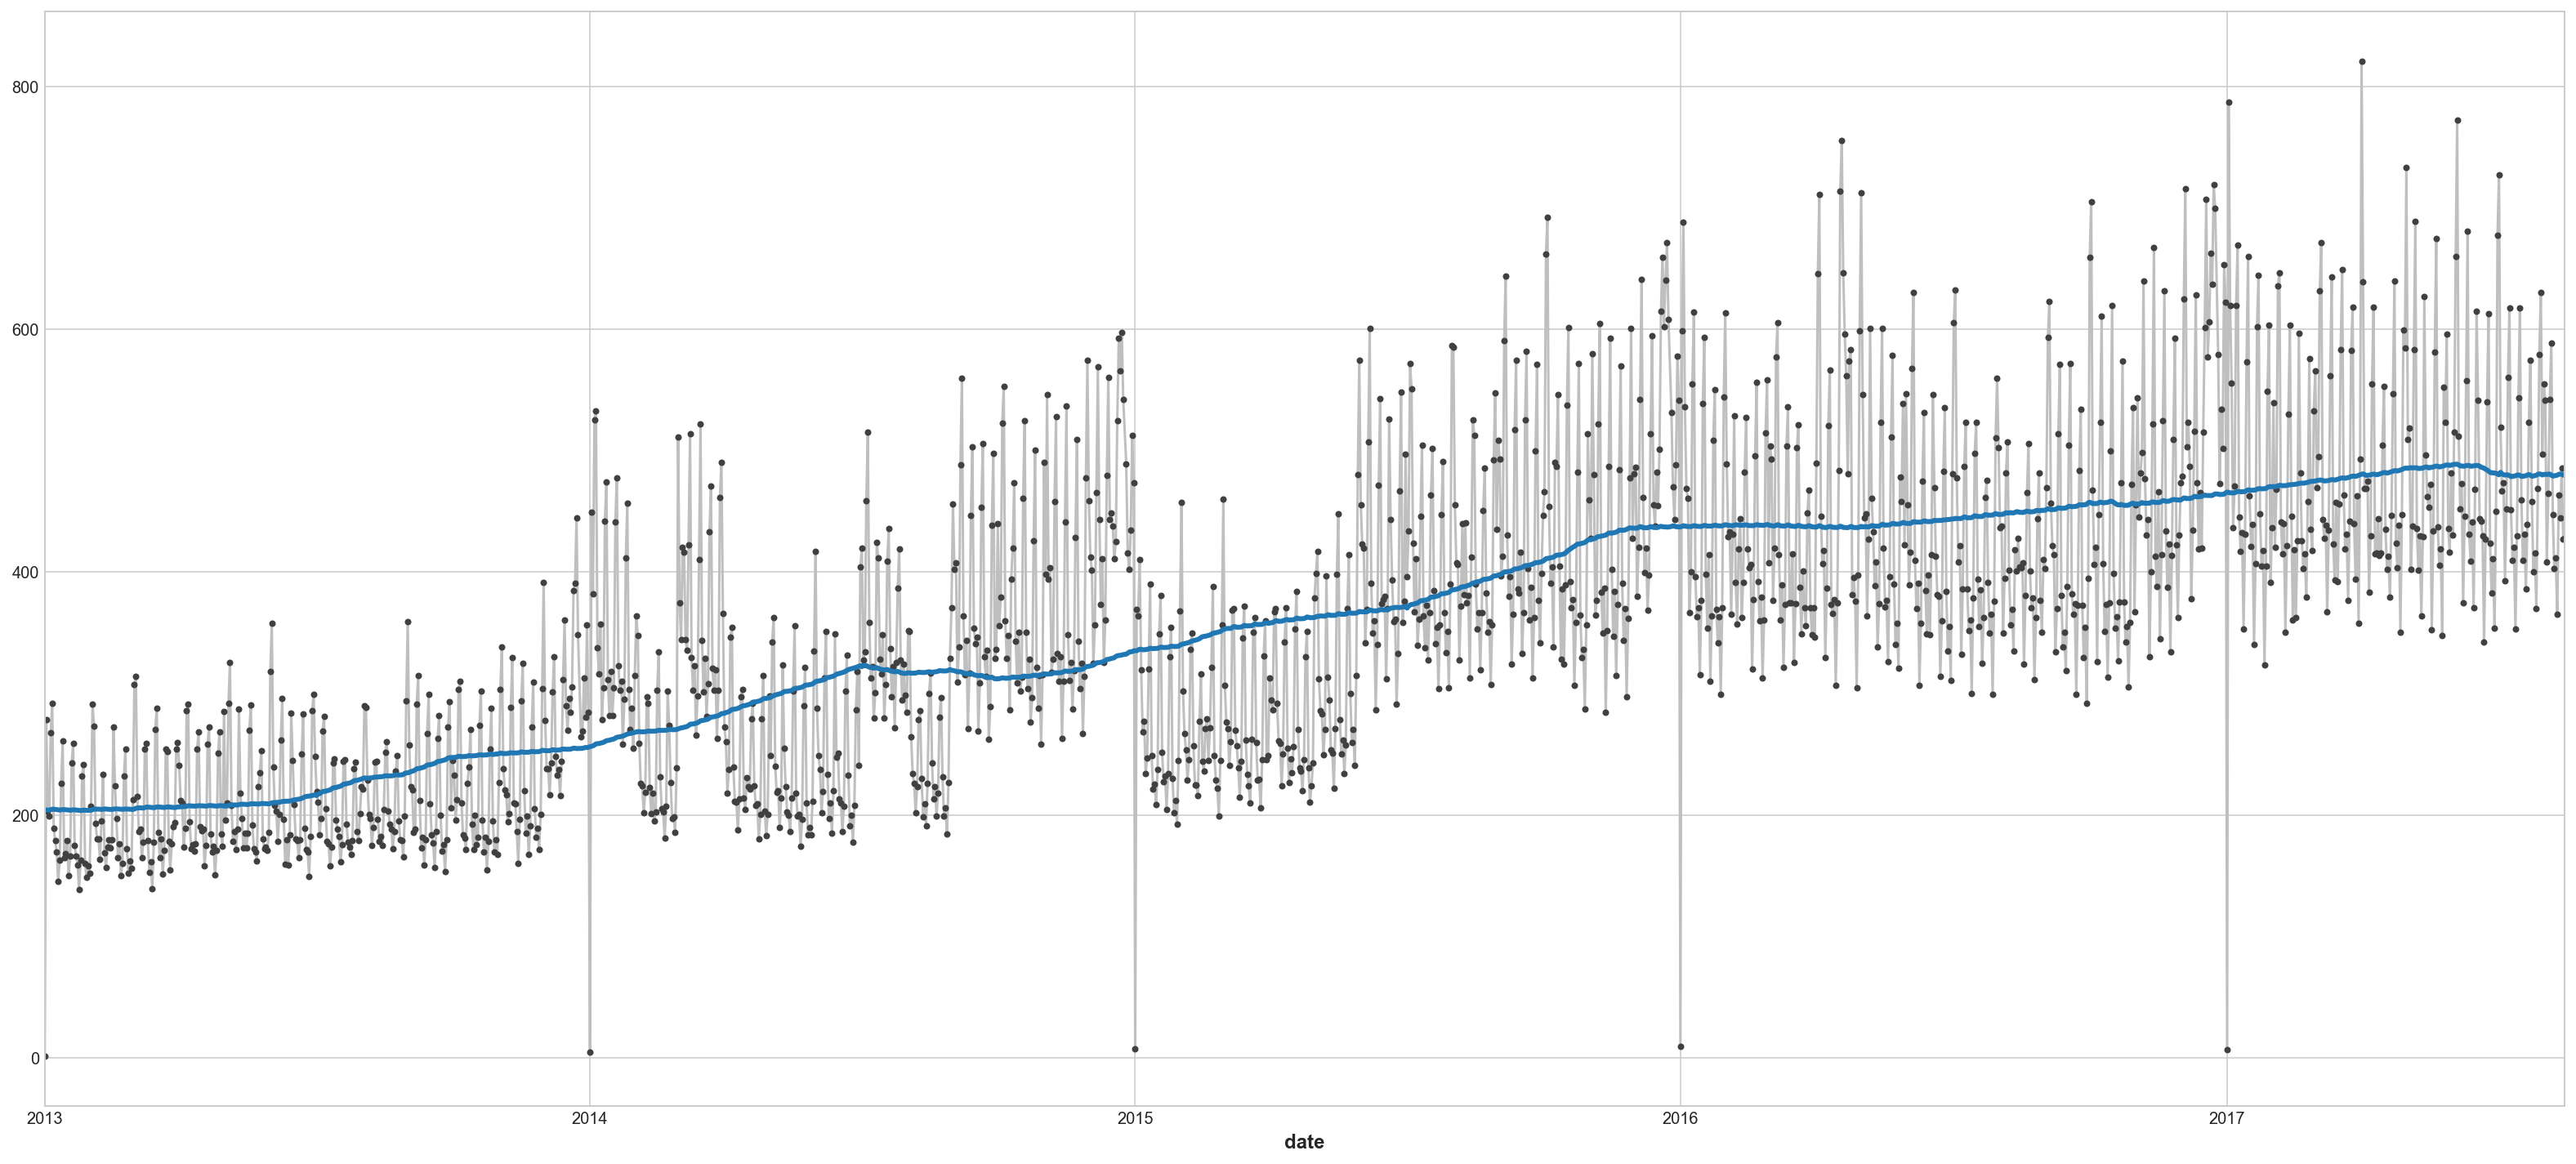

In [43]:
# Média móvel
trend = average_sales.rolling(window=365, center=True, min_periods=183,).mean()
ax = average_sales.plot(**plot_params, alpha=1)
ax = trend.plot(ax=ax, linewidth=3)

In [44]:
# Criar a feature Trend
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=16)

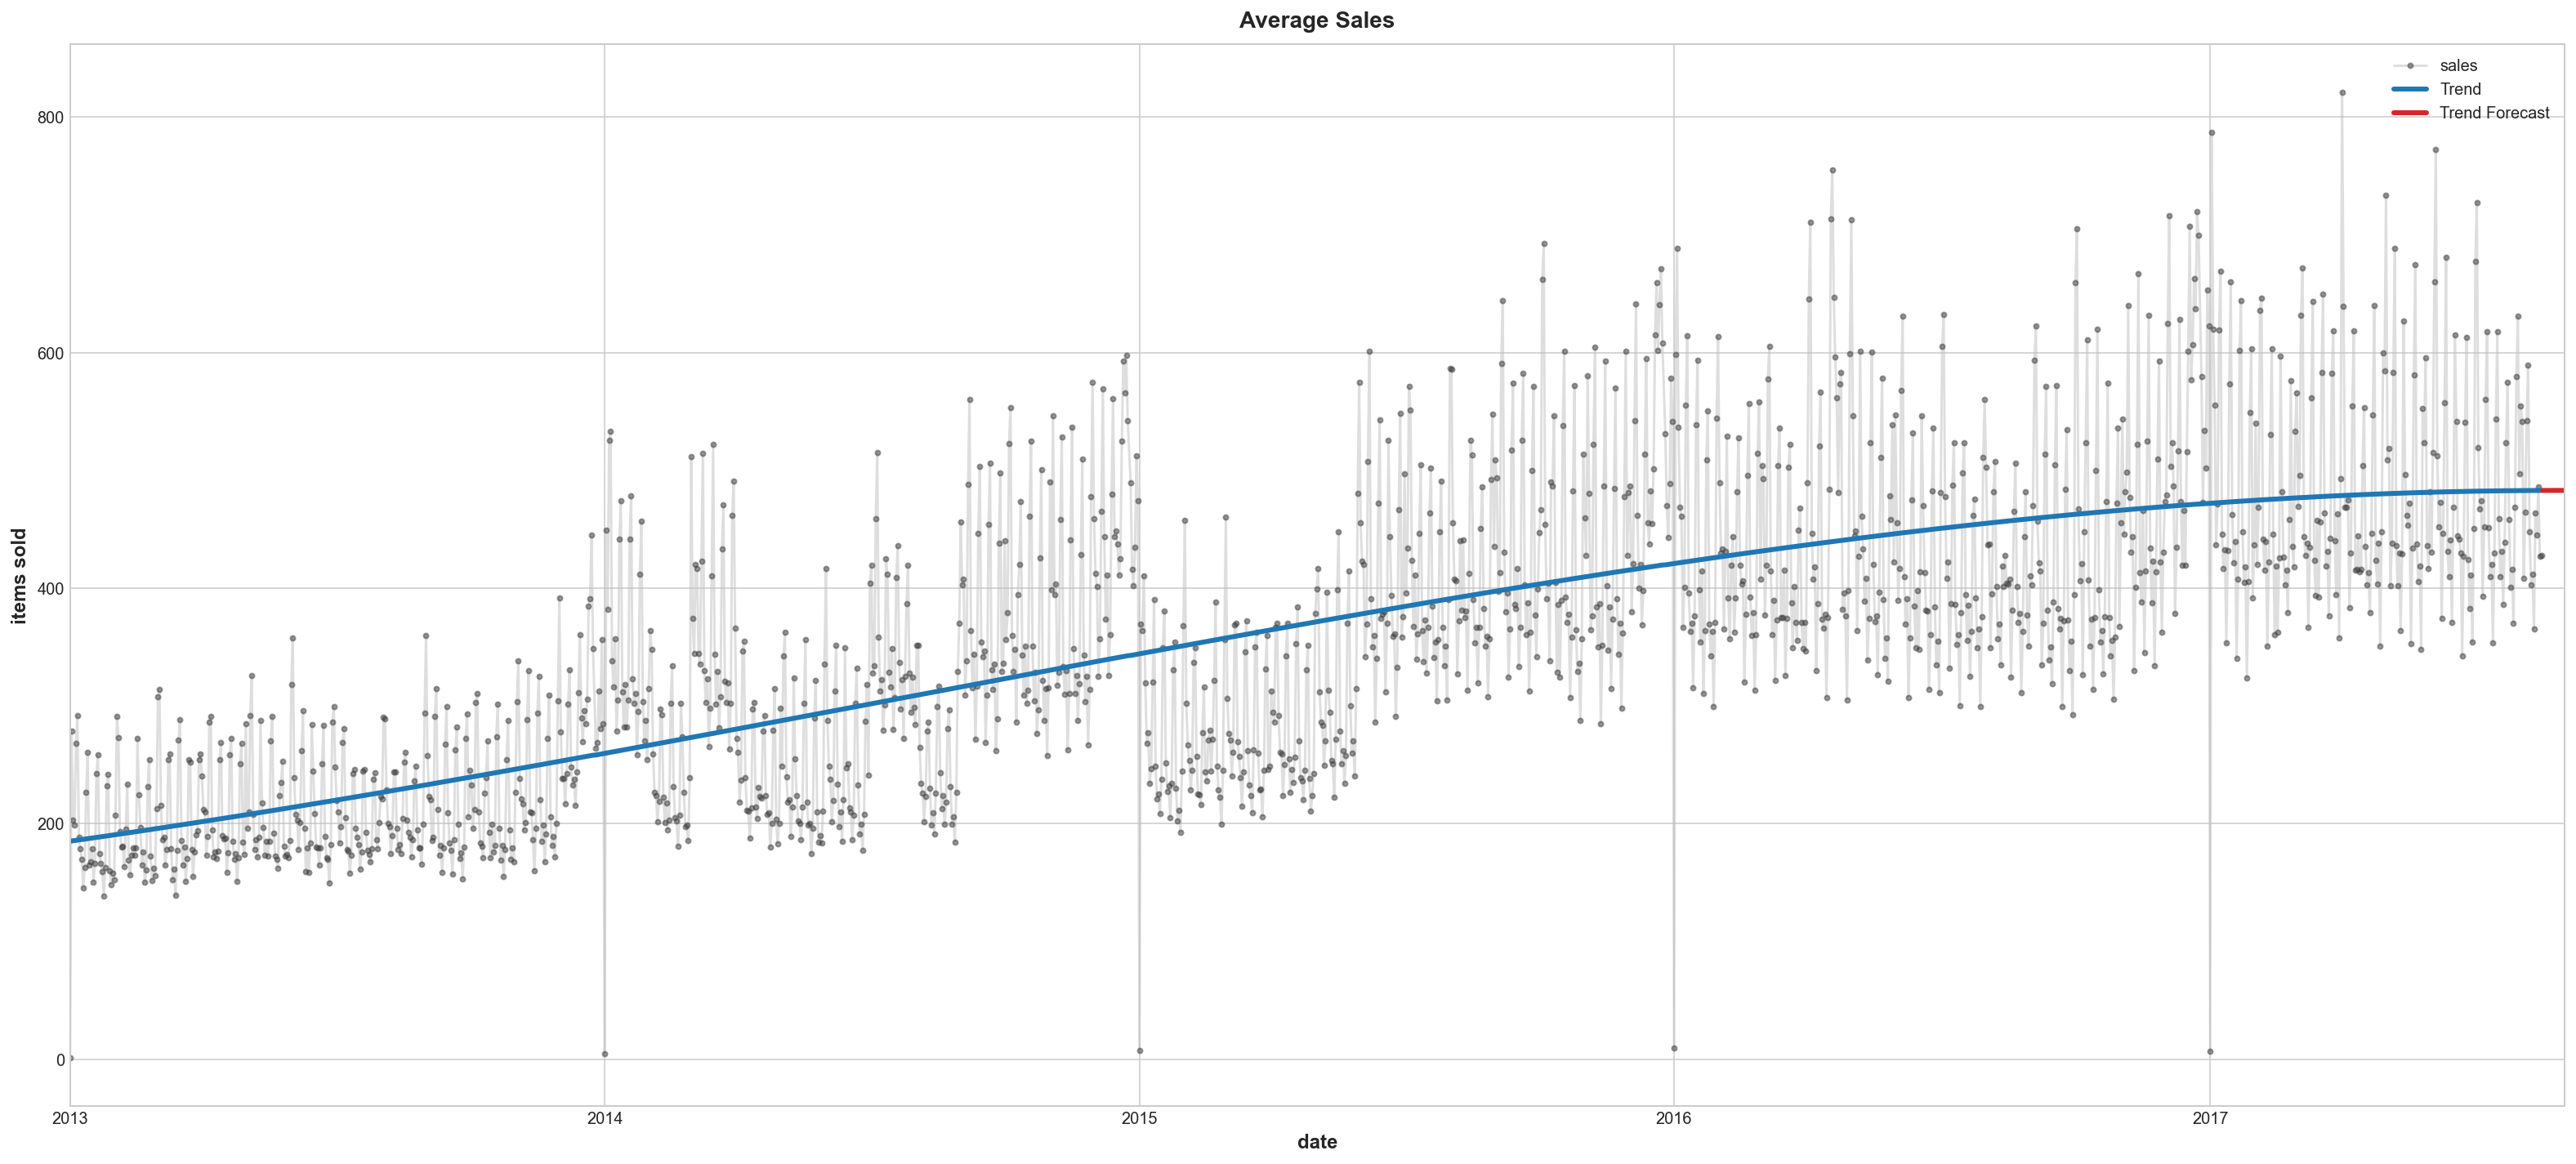

In [45]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [46]:
y = family_sales.loc[:, 'sales'].copy()
X = make_lags(y, lags=4).fillna(0)

# Multistep target
y = make_multistep_target(y, steps=16).fillna(0)

y, X = y.align(X, join='inner', axis=0)

In [47]:
le = LabelEncoder()
X = (X
    .stack('family')
    .reset_index('family')  
    .assign(family=lambda x: le.fit_transform(x.family))
)
y = y.stack('family')

display(y)

y_step_1     y_step_2    y_step_3  ...   y_step_14   y_step_15   y_step_16
date       family                                                            ...                                    
2013-01-01 AUTOMOTIVE                     0.000000     4.722222    2.981482  ...    3.000000    3.055556    3.166667
           BABY CARE                      0.000000     0.000000    0.000000  ...    0.000000    0.000000    0.000000
           BEAUTY                         0.037037     3.833333    2.314815  ...    1.648148    2.037037    2.574074
           BEVERAGES                     15.000000  1335.036987  964.907410  ...  929.537048  863.037048  909.666687
           BOOKS                          0.000000     0.000000    0.000000  ...    0.000000    0.000000    0.000000
...                                            ...          ...         ...  ...         ...         ...         ...
2017-08-15 POULTRY                      325.679810     0.000000    0.000000  ...    0.000000    0.000000    0.000000
           PREPARED FOODS                85.954132     0.000000    0.000000  ...    0.000000    0.000000    0.000000
           PRODUCE                     2316.832764     0.000000    0.000000  ...    0.000000    0.000000    0.000000
           SCHOOL AND OFFICE SUPPLIES    46.851852     0.000000    0.000000  ...    0.000000    0.000000    0.000000
           SEAFOOD                       17.966240     0.000000    0.000000  ...    0.000000    0.000000    0.000000

[55572 rows x 16 columns]

## Regressão Linear com Support Vector Regression

In [48]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
# Start and end of training date (based on plots above)
start_date = '2017-04-30' 
end_date = '2017-08-15'

In [50]:
y = train.unstack(['store_nbr', 'family']).loc[start_date:end_date]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
X = dp.in_sample()
X = X.join(calendar)
X.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521


In [51]:
# Predicting for the next 16 days
X_test = dp.out_of_sample(steps = 16)
X_test = X_test.join(calendar)
X_test.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969


In [52]:
lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(X, y)

yfit_lnr = pd.DataFrame(lnr.predict(X), index = X.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(X_test), index = X_test.index, columns = y.columns).clip(0.)

C:\Users\Original\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [53]:
svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(X, y)

yfit_svr = pd.DataFrame(svr.predict(X), index = X.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(X_test), index = X_test.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = X.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = X_test.index, columns = y.columns).clip(0.)

In [54]:
y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)),'\n')

print('LNR MAE :', meanabsoluteerror(y, yfit_lnr))
print('SVR MAE :', mae(y, yfit_svr))
print('Mean MAE :', mae(y, yfit_mean))

LNR RMSLE : 0.4352360066627403
SVR RMSLE : 0.45835116766840617
Mean RMSLE : 0.4173509403096373 



NameError: name 'mae' is not defined

In [ ]:
y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)),'\n')

print('LNR MAE :', mae(y, yfit_lnr))
print('SVR MAE :', mae(y, yfit_svr))
print('Mean MAE :', mae(y, yfit_mean))

### Resultado final

In [ ]:
y_sub = ypred_mean.stack(['store_nbr', 'family'])

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['sales'] = y_sub.values
sub.head()
sub.to_csv('submission.csv', index = False)